In [4]:
import numpy as np
import pandas as pd
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt

# 데이터 불러오기
votes = pd.read_csv('./datasets/senate/votes.csv', header=None).to_numpy()
with open('./datasets/senate/senators.txt') as f:
    senators = [line.strip() for line in f]

parties = [senator.split('(')[1][0] for senator in senators]

In [6]:
def LogLikelihood(X, Z, theta, pi):
    N, D = X.shape
    K = theta.shape[0]
    log_likelihood = 0
    
    for i in range(N):
        component = Z[i]
        log_likelihood += np.log(pi[component])
        for d in range(D):
            if X[i, d] != -1:  # 결측값은 무시
                log_likelihood += X[i, d] * np.log(theta[component, d]) + (1 - X[i, d]) * np.log(1 - theta[component, d])
    
    return log_likelihood

def GibbsSampling(X, K, alpha, beta_params, alpha_dir, num_iterations):
    N, D = X.shape
    Z = np.random.choice(K, N)
    theta = np.random.beta(alpha, beta_params, (K, D))
    pi = np.random.dirichlet(alpha_dir)
    
    log_likelihoods = []
    
    for it in range(num_iterations):
        # Z 샘플링, Component
        for i in range(N):
            probs = np.array([pi[k] * np.prod([theta[k, d]**X[i, d] * (1-theta[k, d])**(1-X[i, d]) 
                                               for d in range(D) if X[i, d] != -1])
                              for k in range(K)])
            probs /= probs.sum()
            Z[i] = np.random.choice(K, p=probs)
        
        # theta 샘플링, 성공확률(Success Probability)
        for k in range(K):
            for d in range(D):
                X_kd = X[:, d][Z == k]
                X_kd = X_kd[X_kd != -1]
                a_post = alpha + X_kd.sum()
                b_post = beta_params + len(X_kd) - X_kd.sum()
                theta[k, d] = np.random.beta(a_post, b_post)
        
        # mixing proportions 샘플링
        n_k = np.array([np.sum(Z == k) for k in range(K)])
        pi = np.random.dirichlet(alpha_dir + n_k)
        
        # loglikelihood계산
        log_likelihood = LogLikelihood(X, Z, theta, pi)
        print(f"Iteration {it + 1}, Log-Likelihood: {log_likelihood}")

        log_likelihoods.append(log_likelihood)
    return Z, theta, pi, log_likelihoods

K = 3  # Component 수
alpha = 1  # Beta prior를 위한 하이퍼파라미터 
beta_params = 1
alpha_dir = np.ones(K)  # 디레클레 분포를 위한 하이퍼파라미터
num_iterations = 200

# Perform Gibbs sampling
Z, theta, pi, log_likelihoods = GibbsSampling(votes, K, alpha, beta_params, alpha_dir, num_iterations)

Iteration 1, Log-Likelihood: -24615.84647041494
Iteration 2, Log-Likelihood: -10962.039871569834
Iteration 3, Log-Likelihood: -10230.17150190631
Iteration 4, Log-Likelihood: -10319.080819461164
Iteration 5, Log-Likelihood: -10281.127300256685
Iteration 6, Log-Likelihood: -10266.428963441387
Iteration 7, Log-Likelihood: -10229.013856319036
Iteration 8, Log-Likelihood: -10211.529777200349
Iteration 9, Log-Likelihood: -10248.716451853072
Iteration 10, Log-Likelihood: -10324.582513979407
Iteration 11, Log-Likelihood: -10208.010700079554
Iteration 12, Log-Likelihood: -10265.101980015479
Iteration 13, Log-Likelihood: -10246.071000372913
Iteration 14, Log-Likelihood: -10258.147628723707
Iteration 15, Log-Likelihood: -10236.884506178938
Iteration 16, Log-Likelihood: -10245.305661964017
Iteration 17, Log-Likelihood: -10288.712229296169
Iteration 18, Log-Likelihood: -10345.658719966903
Iteration 19, Log-Likelihood: -10326.595302516427
Iteration 20, Log-Likelihood: -10257.963167109112
Iteration 2

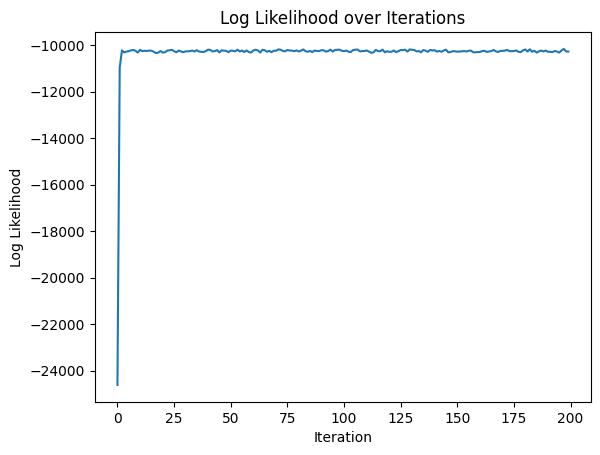

In [8]:
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood over Iterations')
plt.show()

np.save('./results/Bernolli_Beta_mixture_Z.npy', Z)
np.save('./results/Bernolli_Beta_mixture_Z.npy', Z)
np.save('./results/Bernolli_Beta_mixture_Z.npy', Z)